In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error


from supplemental_english import REGION_CODES, GOVERNMENT_CODES


In [14]:
df_raw = pd.read_csv('train.csv')
print(df_raw.info())
df_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51635 non-null  int64 
 1   plate   51635 non-null  object
 2   date    51635 non-null  object
 3   price   51635 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB
None


,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000
5,6,B400BB750,2022-04-09 00:00:00,50000
6,7,P666OM790,2024-11-14 00:00:00,300000
7,8,C080KP777,2021-06-10 12:30:00,300000
8,9,E737AY550,2024-07-31 00:00:00,60000
9,10,C001KK750,2024-07-09 08:48:39,420000


In [10]:
region_codes_to_region = {}
for key, val in REGION_CODES.items():
    if type(val) == list:
        for v in val:
            region_codes_to_region[v] = key
    else:
        region_codes_to_region[val] = key
        
def get_region(plate):
    region_code = plate[6:]
    if region_codes_to_region[region_code]:
        return region_codes_to_region[region_code]
    else:
        return np.nan 

def get_government(plate):
    num_range = int(plate[1:4])
    letters = plate[0] + plate[4:6]
    regionCodes = plate[6:]
    
    for key, value in GOVERNMENT_CODES.items():
        key_letter, (start, end), key_region = key
        if letters == key_letter and regionCodes == key_region and int(start) <= num_range <= int(end):
            return value
    return (np.nan, np.nan, np.nan, np.nan)


In [15]:
def preprocess(df_raw):
    df = df_raw.copy()
    df["region"] = df["plate"].apply(get_region)
    df[['text', 'forbidenToBuy', 'advantageOnRoad', 'significance']] = df['plate'].apply(get_government).apply(pd.Series)
    
    df.drop("text", axis=1, inplace=True)
    df.drop("id", axis=1, inplace=True)
    df.fillna(0, inplace=True) # Most of the newly added columns have NaN values, we will replace it with 0, since they are mostly binary and categorical(significance)
    
    df["date"] = df["date"].astype('datetime64[ns]')
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.dayofweek
    df.drop("date", axis=1, inplace=True)
    
    df["same_number_first"] = df["plate"].apply(lambda x: x[1] == x[2] == x[3])
    df["same_number_second"] = df["plate"].apply(lambda x: x[6] == x[7] == x[8] if len(x) == 9 else x[6] == x[7])
    df["matching_numbers"] = df["plate"].apply(lambda x: x[1:4] == x[6:])
    df["palindrom_numbers_first"] = df["plate"].apply(lambda x: x[1:4] == x[1:4][::-1])
    df["palindrom_numbers_second"] = df["plate"].apply(lambda x: x[6:] == x[6:][::-1])
    df["palidrom_all_numbers"] = df["plate"].apply(lambda x: x[1:4] + x[6:] == str(x[1:4] + x[6:])[::-1])
    df["cool_number"] = df["plate"].apply(lambda x: x[1:4] in ["001", "007", "100", "200", "300", "400", "500", "600", "700", "800", "900"])
    
    df["one_unique_letter"] = df["plate"].apply(lambda x: len(set(x[0] + x[4:6])) == 1)
    
    df["plate"] = df["plate"].astype('category')
    df["region"] = df["region"].astype('category')
    df["forbidenToBuy"] = df["forbidenToBuy"].astype('bool')
    df["advantageOnRoad"] = df["advantageOnRoad"].astype('bool')
    df["significance"] = df["significance"].astype('int')
    df["year"] = df["year"].astype('int')
    df["month"] = df["month"].astype('int')
    df["day"] = df["day"].astype('int')
    df["day_of_week"] = df["day_of_week"].astype('int')
    df["same_number_first"] = df["same_number_first"].astype('bool')
    df["same_number_second"] = df["same_number_second"].astype('bool')
    df["matching_numbers"] = df["matching_numbers"].astype('bool')
    df["palindrom_numbers_first"] = df["palindrom_numbers_first"].astype('bool')
    df["palindrom_numbers_second"] = df["palindrom_numbers_second"].astype('bool')
    df["palidrom_all_numbers"] = df["palidrom_all_numbers"].astype('bool')
    df["one_unique_letter"] = df["one_unique_letter"].astype('bool')
    
    return df


In [17]:
df = preprocess(df_raw)
display(df)
display(df.info())

,plate,price,region,forbidenToBuy,advantageOnRoad,significance,year,month,day,day_of_week,same_number_first,same_number_second,matching_numbers,palindrom_numbers_first,palindrom_numbers_second,palidrom_all_numbers,cool_number,one_unique_letter
0,X059CP797,65000,Moscow,False,False,0,2024,12,26,3,False,False,False,False,True,False,False,False
1,Y800MH790,100000,Moscow Oblast,False,False,0,2024,7,12,4,False,False,False,False,False,False,True,False
2,A212TX77,290000,Moscow,False,False,0,2024,4,18,3,False,True,False,True,True,False,False,False
3,P001AY199,680000,Moscow,False,False,0,2025,1,3,4,False,False,False,False,False,False,True,False
4,P001AY199,750000,Moscow,False,False,0,2025,1,10,4,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51630,X023PP797,70000,Moscow,False,False,0,2025,1,29,2,False,False,False,False,True,False,False,False
51631,M004KA161,1600000,Rostov Oblast,False,False,0,2025,1,31,4,False,False,False,False,True,False,False,False
51632,E888EB199,850000,Moscow,False,False,0,2025,2,6,3,True,False,False,True,False,False,False,False
51633,X023XK77,150000,Moscow,False,False,0,2024,4,24,2,False,True,False,False,True,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   plate                     51635 non-null  category
 1   price                     51635 non-null  int64   
 2   region                    51635 non-null  category
 3   forbidenToBuy             51635 non-null  bool    
 4   advantageOnRoad           51635 non-null  bool    
 5   significance              51635 non-null  int64   
 6   year                      51635 non-null  int64   
 7   month                     51635 non-null  int64   
 8   day                       51635 non-null  int64   
 9   day_of_week               51635 non-null  int64   
 10  same_number_first         51635 non-null  bool    
 11  same_number_second        51635 non-null  bool    
 12  matching_numbers          51635 non-null  bool    
 13  palindrom_numbers_first   51635 non-null  bool

None

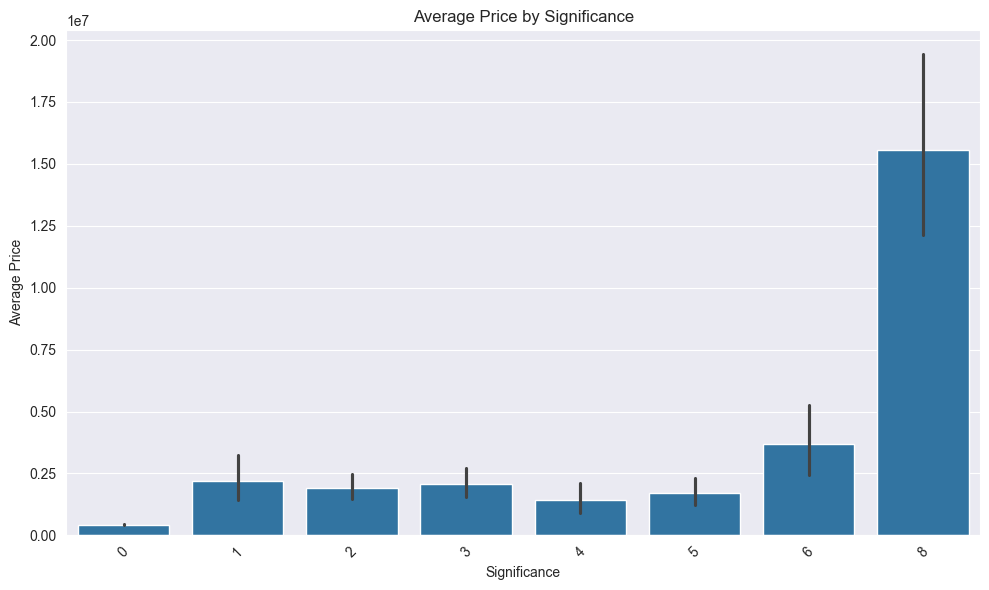

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='significance', y='price', estimator='mean')
plt.title('Average Price by Significance')
plt.xlabel('Significance')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

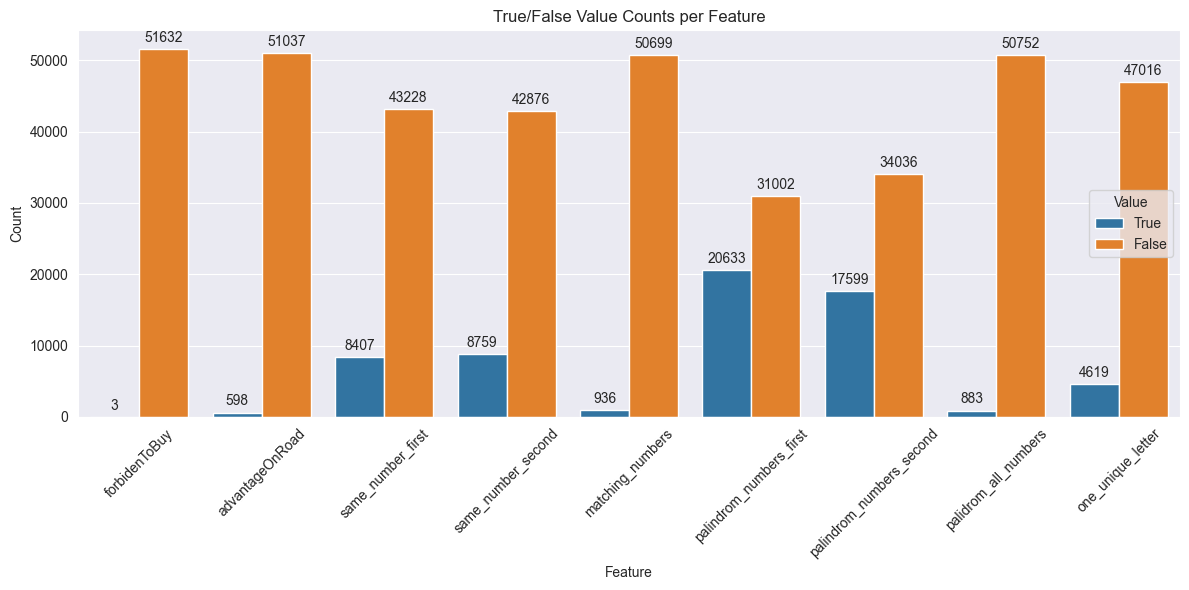

In [20]:
columns = [
    "forbidenToBuy", "advantageOnRoad", "same_number_first", "same_number_second",
    "matching_numbers", "palindrom_numbers_first", "palindrom_numbers_second", "palidrom_all_numbers", "one_unique_letter"
]

data = []
for col in columns:
    true_count = df[col].sum()
    false_count = (~df[col]).sum()  
    data.append({"Feature": col, "Value": "True", "Count": true_count})
    data.append({"Feature": col, "Value": "False", "Count": false_count})

dftest = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=dftest, x='Feature', y='Count', hue='Value')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.xticks(rotation=45)
plt.title("True/False Value Counts per Feature")
plt.tight_layout()
plt.show()

In [22]:
df.loc[:, ~df.columns.isin(["plate", "region"])].corr()["price"].sort_values(ascending=False)

price                       1.000000
significance                0.160626
one_unique_letter           0.158822
palidrom_all_numbers        0.153049
same_number_first           0.134443
same_number_second          0.133817
advantageOnRoad             0.131139
palindrom_numbers_first     0.048635
matching_numbers            0.046933
year                        0.046106
palindrom_numbers_second    0.036246
cool_number                 0.019309
forbidenToBuy              -0.000432
day                        -0.002189
month                      -0.006418
day_of_week                -0.011604
Name: price, dtype: float64

# Predikce

In [76]:
X = df.copy()
X.drop("plate", axis=1, inplace=True)

X_train = X[~((X["year"] == 2024) & ((X["month"] == 11) | (X["month"] == 12) ))]
y_train = X_train["price"]
X_train.drop("price", axis=1, inplace=True)

X_val = X[(X["year"] == 2024) & ((X["month"] == 11) | ( (X["month"] == 12) & (X["day"].isin(range(5)))))]
y_val = X_val["price"]
X_val.drop("price", axis=1, inplace=True)

X_test = X[(X["year"] == 2024) & (X["month"] == 12) & ~(X["day"].isin(range(5)))]
y_test = X_test["price"]
X_test.drop("price", axis=1, inplace=True)

C:\Users\Tom\AppData\Local\Temp\ipykernel_16040\3065001717.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop("price", axis=1, inplace=True)
C:\Users\Tom\AppData\Local\Temp\ipykernel_16040\3065001717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.drop("price", axis=1, inplace=True)
C:\Users\Tom\AppData\Local\Temp\ipykernel_16040\3065001717.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop("price

In [77]:
print(f"Size train - X: {X_train.shape}, y: {y_train.shape}")
print(f"Size val - X: {X_val.shape}, y: {y_val.shape}")
print(f"Size test - X: {X_test.shape}, y: {y_test.shape}")

Size train - X: (45043, 16), y: (45043,)
Size val - X: (3113, 16), y: (3113,)
Size test - X: (3479, 16), y: (3479,)


In [42]:
X[X["year"] == 2024]["month"].value_counts()

month
12    3932
11    2660
10    2256
9     1905
8     1836
7     1684
6     1614
5     1528
3     1258
4     1257
2     1174
1     1129
Name: count, dtype: int64

## XGBoost

In [30]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid

In [35]:
param_grid = {
    "eta" : [0.05 ,0.1, 0.6],
    "gamma" : [0, 1,  100, 1000],
    "max_depth" : [3, 6, 10],
    "subsample" : [0.9, 0.7,  0.3],
    "n_estimators" : [100, 1000, 10000]
}

In [36]:
param_comb = ParameterGrid(param_grid)
best_score = float('inf')
best_param = None
for par in param_comb:
    clf = XGBRegressor(eval_metric="rmse", enable_categorical= True, **par)
    clf.fit(X_train, y_train, verbose=10)
    
    rmse_score = root_mean_squared_error(y_val, clf.predict(X_val))
    if rmse_score < best_score:
        best_score = rmse_score
        best_param = par
    
    print(f"RMSE: {rmse_score} for param: {par}")



RMSE: 1300052.125 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
RMSE: 1300738.125 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
RMSE: 1302064.75 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.3}
RMSE: 1282096.625 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.9}
RMSE: 1282646.625 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
RMSE: 1302085.0 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.3}
RMSE: 1353492.5 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 10000, 'subsample': 0.9}
RMSE: 1359384.375 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 10000, 'subsample': 0.7}
RMSE: 1400031.875 for param: {'eta': 0.05, 'gamma': 0, 'max_depth': 3, 'n_estimators': 10000, 'subsample': 0.3}
RMSE: 

In [37]:
best_param

{'eta': 0.1, 'gamma': 0, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7}

In [38]:
clf = XGBRegressor(eval_metric="rmse", enable_categorical= True, **best_param)
clf.fit(X_train, y_train, verbose=10)
pred_val = clf.predict(X_val)
rmse_val = root_mean_squared_error(y_val, pred_val)

pred_test = clf.predict(X_test)
rmse_test = root_mean_squared_error(y_test, pred_test)

print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")

Validation RMSE: 1260331.125
Test RMSE: 2604080.5


In [81]:
pred_s = pd.Series(pred)

In [83]:
y_val

35045     250000
16523      50000
23441     950000
3458     2850000
33151      50000
          ...   
42442     170000
37208      30000
27420     320000
9987      400000
51585     300000
Name: price, Length: 5163, dtype: int64

In [87]:
pred_s

0       330891.625000
1       467945.000000
2       467945.000000
3       550317.750000
4       339656.437500
            ...      
5158    264208.156250
5159    257283.671875
5160    467945.000000
5161    517315.093750
5162    541552.937500
Length: 5163, dtype: float32

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

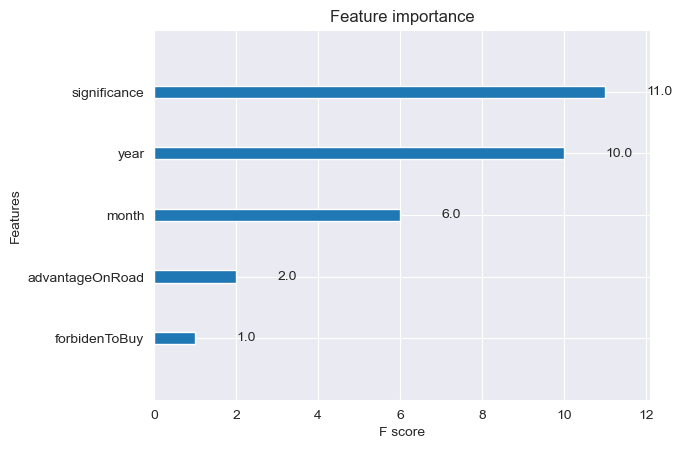

In [72]:
xgb.plot_importance(bst)